# Importing Libraries


In [2]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing Single Audio


In [3]:
random_file_name = "C:\\Users\\Admin\\OneDrive\\Desktop\\Music Genre Classification System\\Data\\genres_original\\disco\\disco.00004.wav"

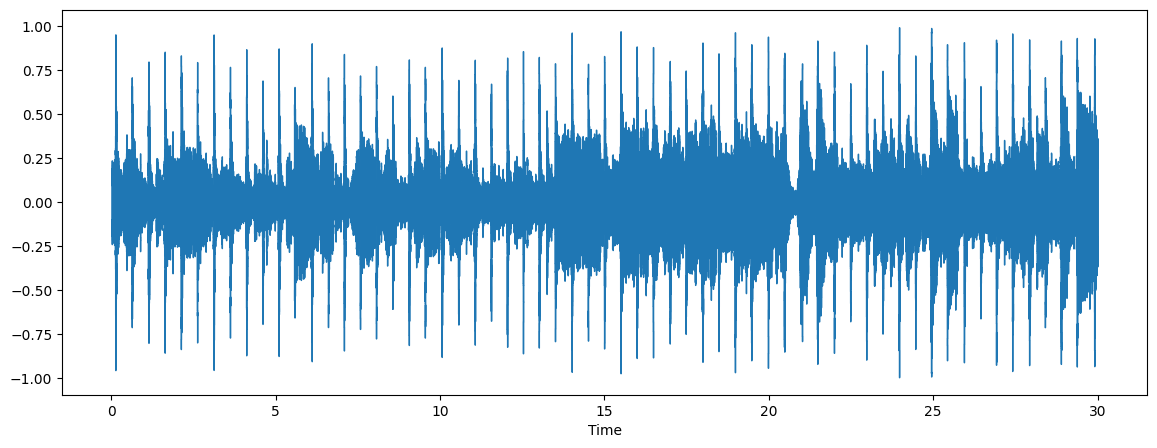

In [4]:
x, sr = librosa.load(random_file_name, sr=44100)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(x, sr=sr)

In [5]:
from IPython.display import Audio
Audio(data=x, rate=sr)

# Doing Visualization on chunks of audio

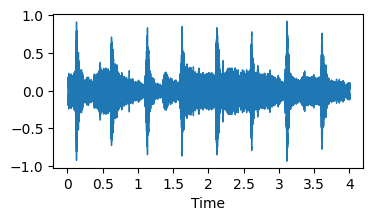

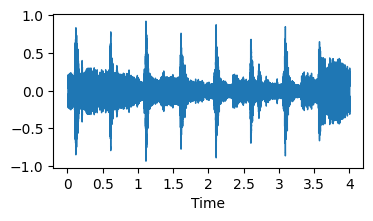

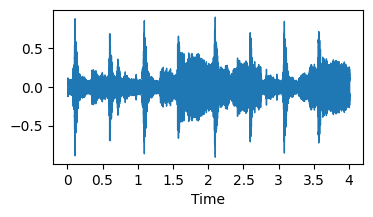

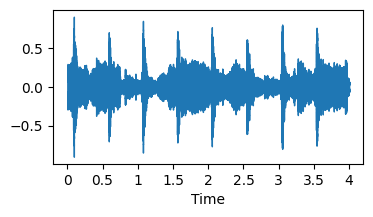

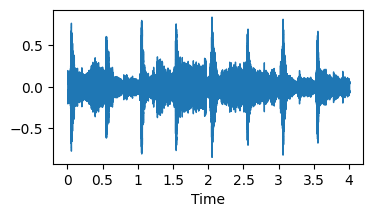

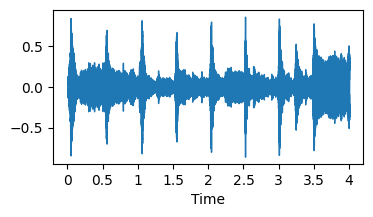

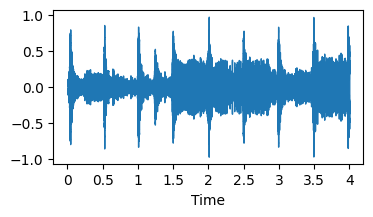

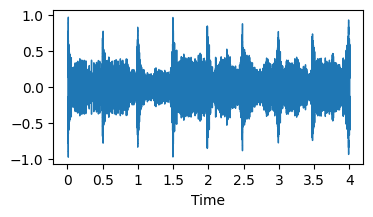

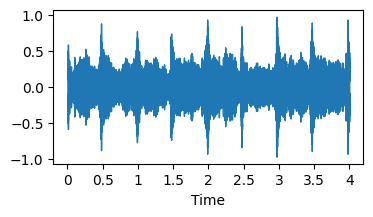

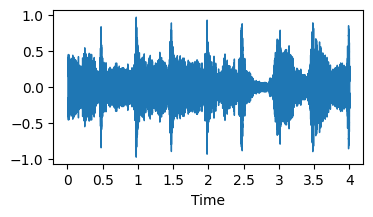

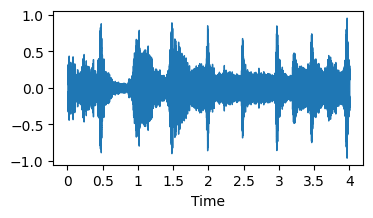

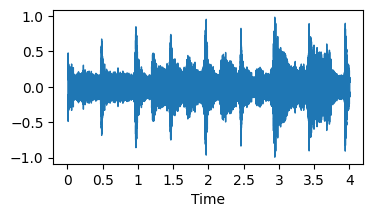

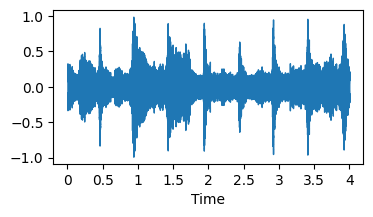

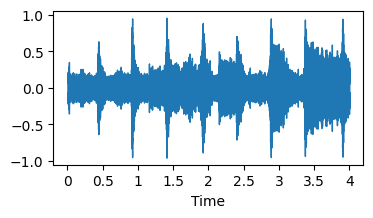

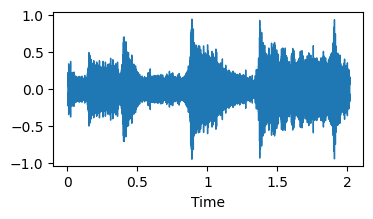

In [6]:
audio_path = "C:\\Users\\Admin\\OneDrive\\Desktop\\Music Genre Classification System\\Data\\genres_original\\disco\\disco.00004.wav"
y, sr = librosa.load(audio_path, sr=None)  # sr=None to keep the original sampling rate

# Define the duration of each chunk and overlap
chunk_duration = 4  # seconds
overlap_duration = 2  # seconds

# Convert durations to samples
chunk_samples = chunk_duration * sr
overlap_samples = overlap_duration * sr

# Calculate the number of chunks
num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

# Iterate over each chunk
for i in range(num_chunks):
    # Calculate start and end indices of the chunk
    start = i * (chunk_samples - overlap_samples)
    end = start + chunk_samples
    
    # Extract the chunk of audio
    chunk = y[start:end]
    plt.figure(figsize=(4, 2))
    librosa.display.waveshow(chunk, sr=sr)
    plt.show()

# Melspectrogram Visualization

In [7]:
#Plotting Melspectrogram of Entire audio
def plot_melspectrogram(y,sr):
    # Compute the spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # Convert to decibels (log scale)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    # Visualize the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()

In [8]:
def plot_melspectrogram_chunks(y,sr):
    # Define the duration of each chunk and overlap
    chunk_duration = 4  # seconds
    overlap_duration = 2  # seconds
    
    # Convert durations to samples
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr
    
    # Calculate the number of chunks
    num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
    
    # Iterate over each chunk
    for i in range(num_chunks):
        # Calculate start and end indices of the chunk
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples
        
        # Extract the chunk of audio
        chunk = y[start:end]
        
        # Compute the Mel spectrogram for the chunk
        mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sr)
        print(mel_spectrogram.shape)
        spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        # Visualize the spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.tight_layout()
        plt.show()

(128, 173)


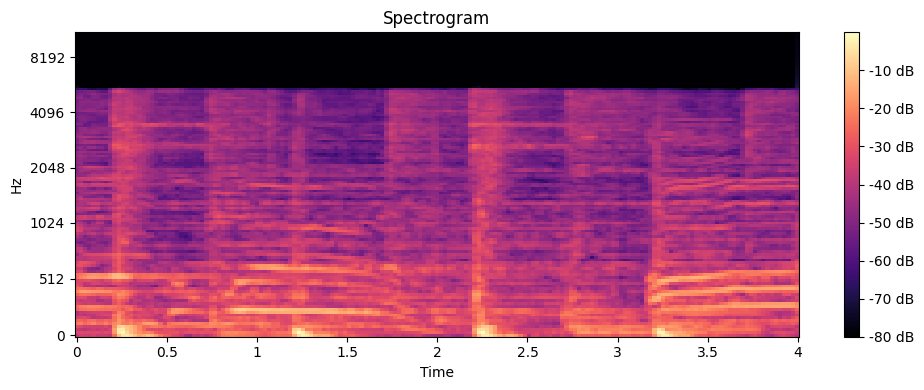

(128, 173)


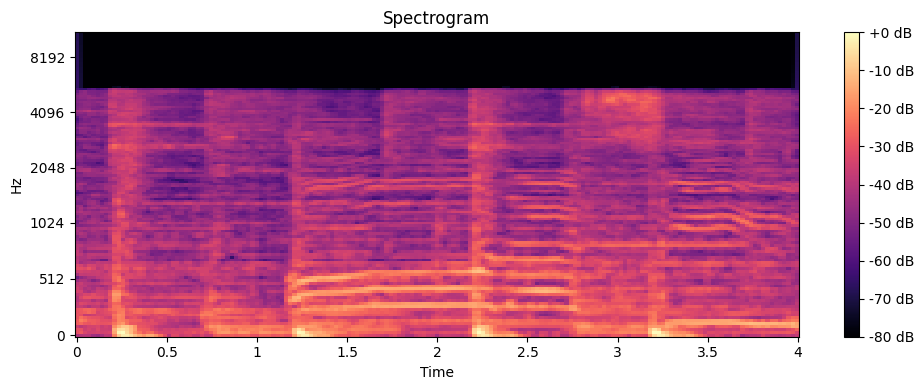

(128, 173)


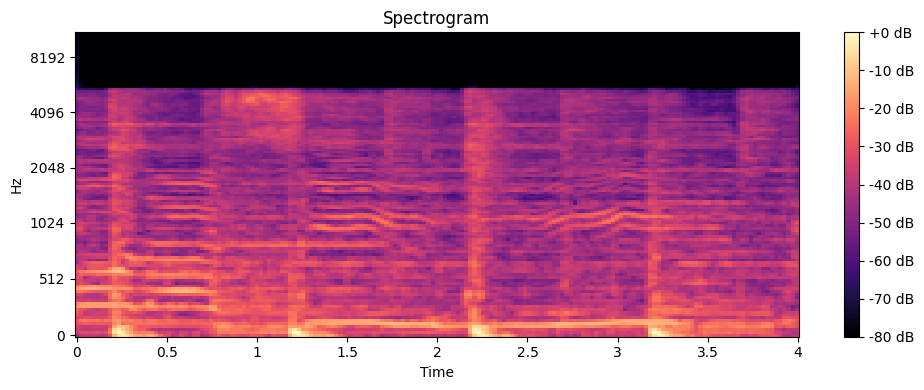

(128, 173)


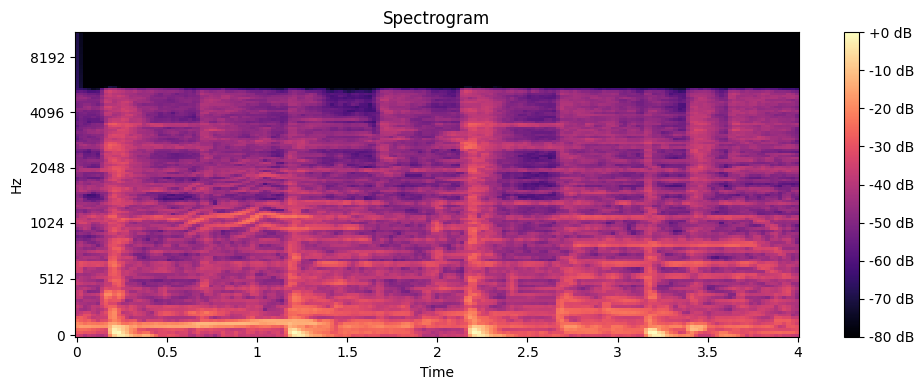

(128, 173)


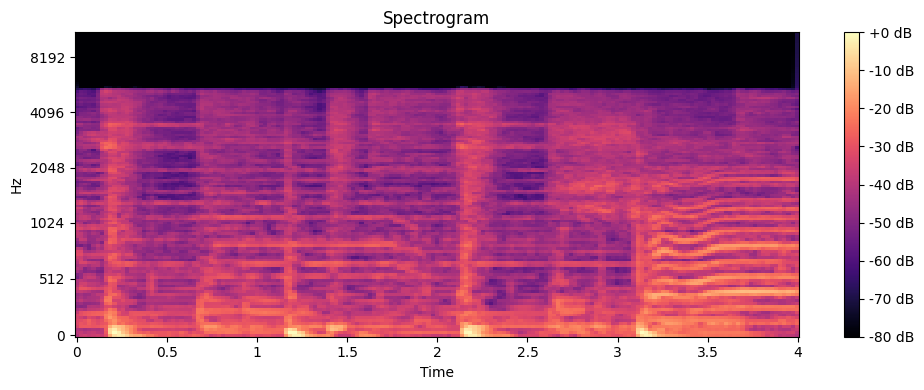

(128, 173)


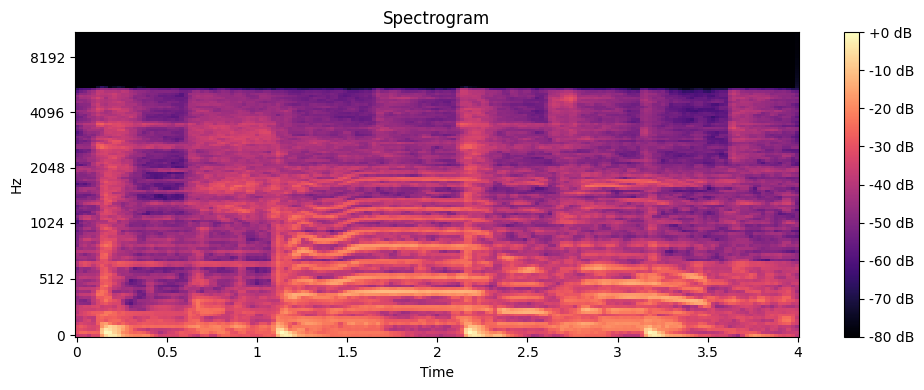

(128, 173)


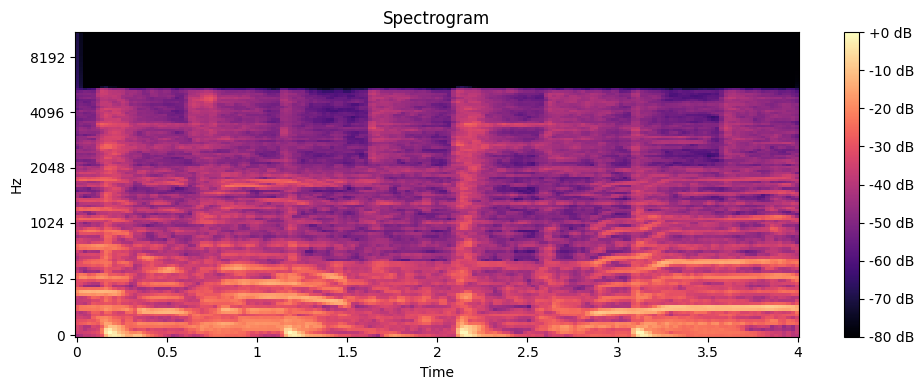

(128, 173)


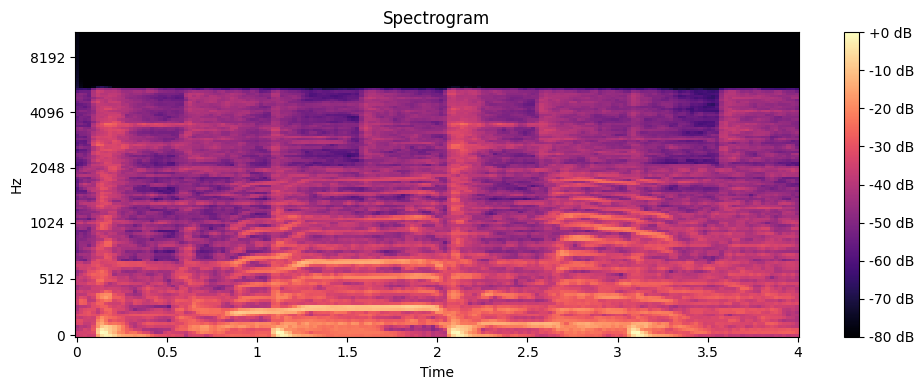

(128, 173)


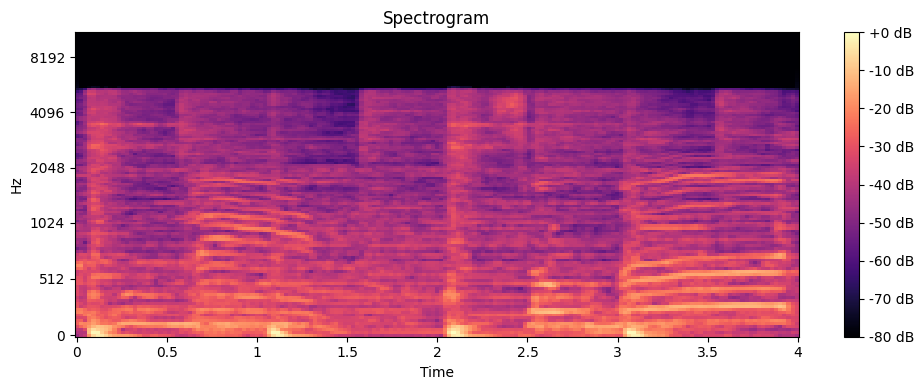

(128, 173)


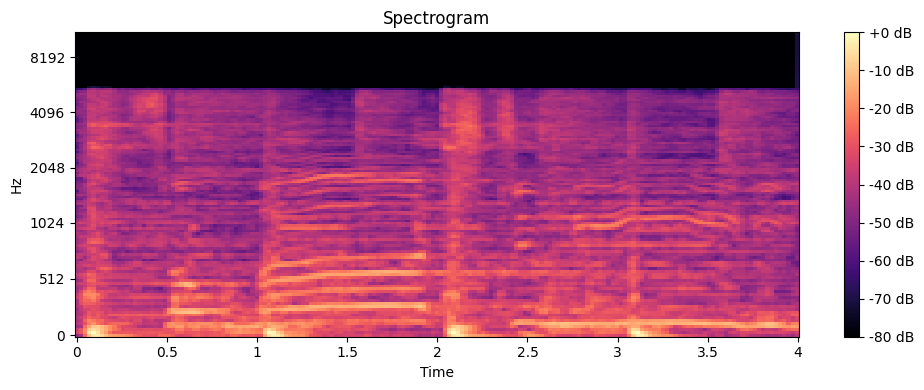

(128, 173)


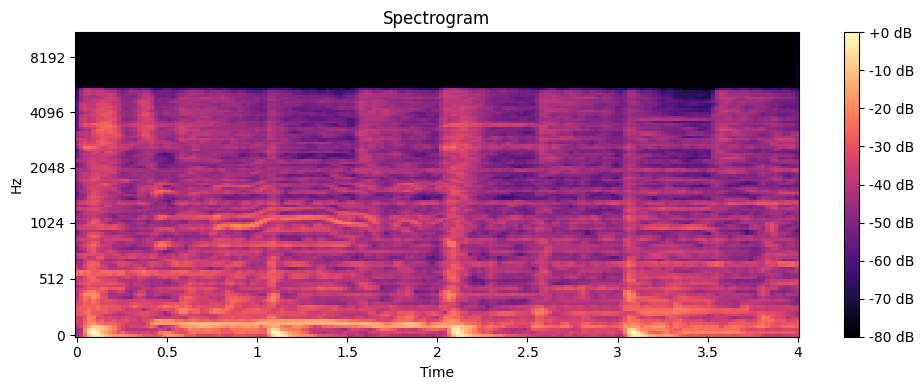

(128, 173)


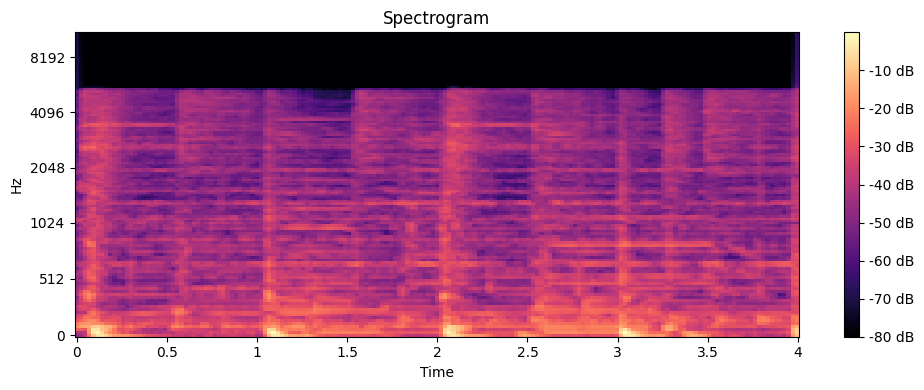

(128, 173)


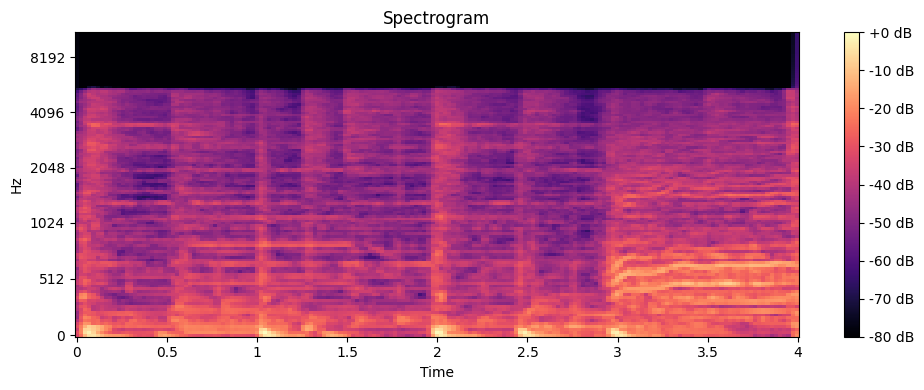

(128, 173)


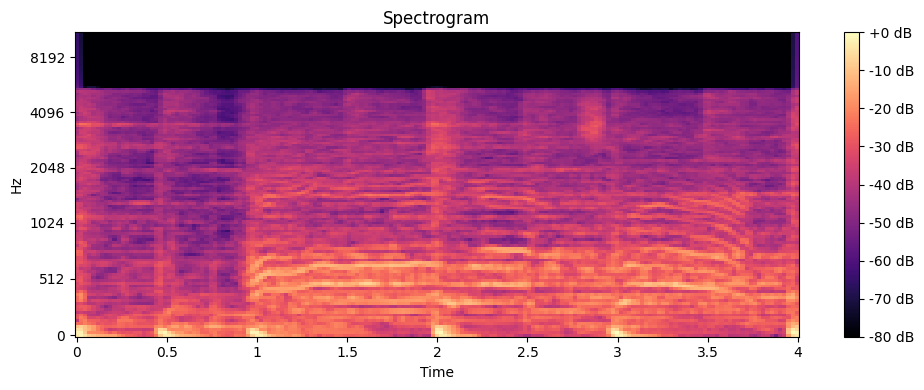

(128, 173)


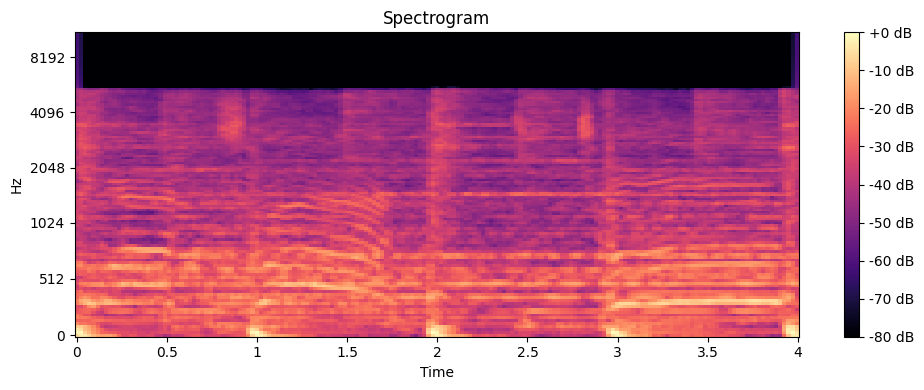

(128, 173)


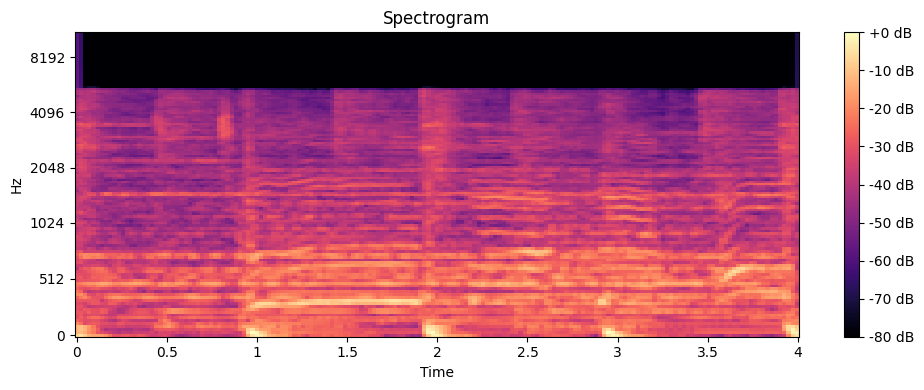

(128, 173)


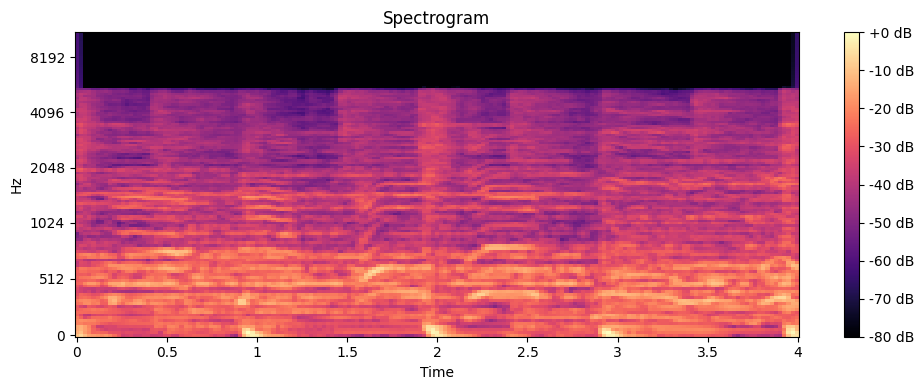

(128, 173)


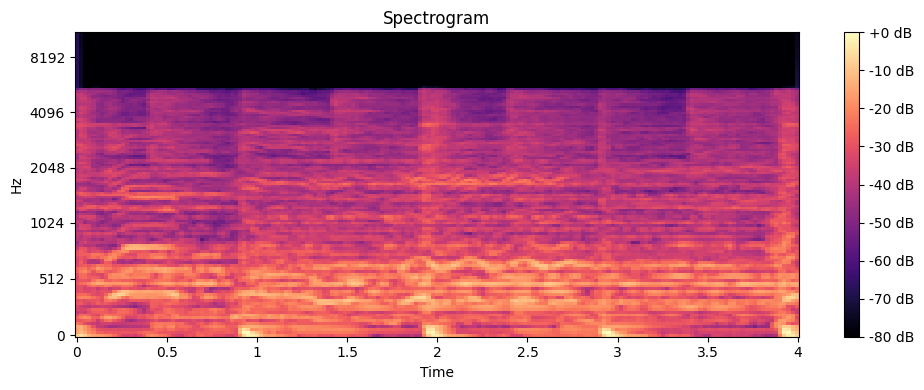

(128, 173)


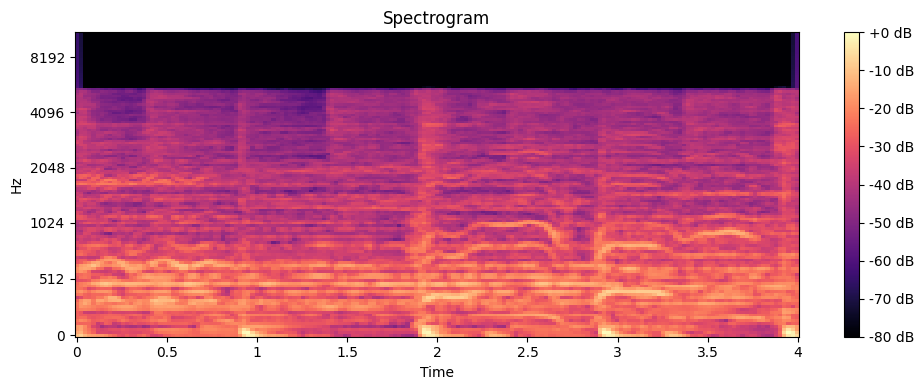

(128, 173)


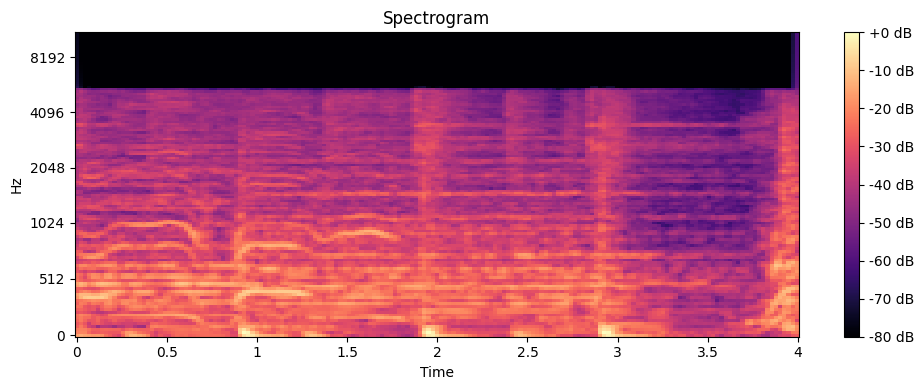

(128, 173)


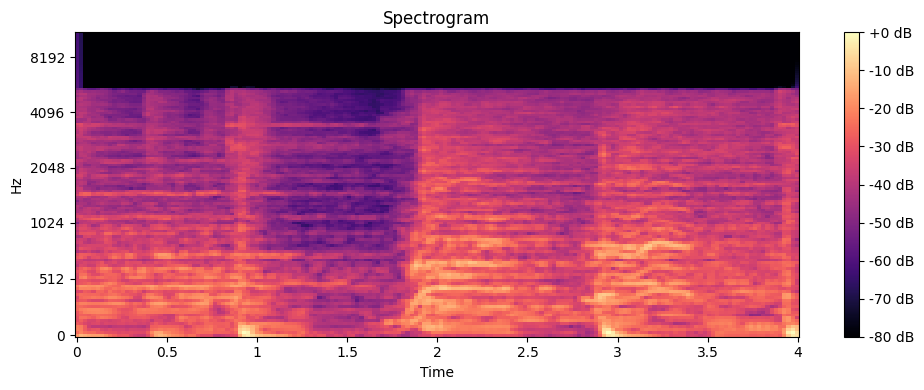

(128, 173)


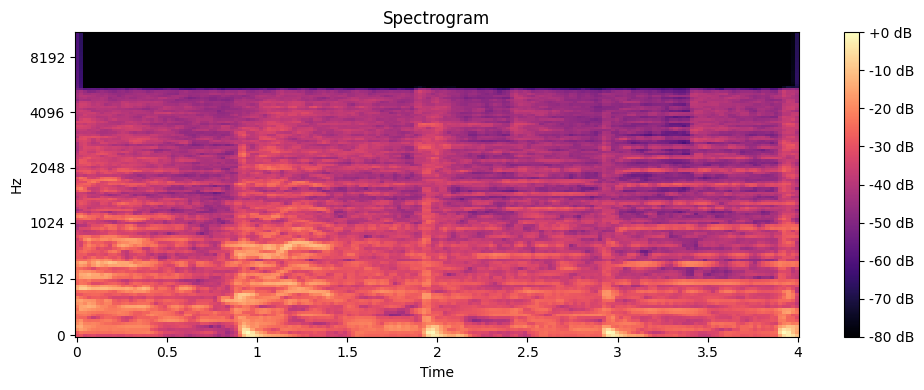

(128, 173)


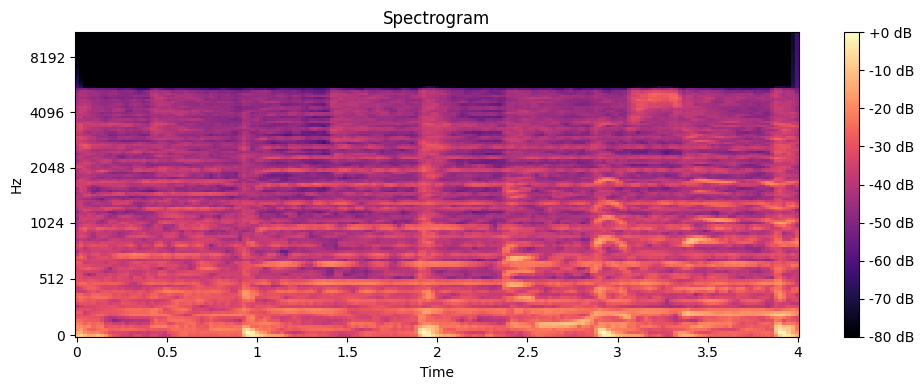

(128, 173)


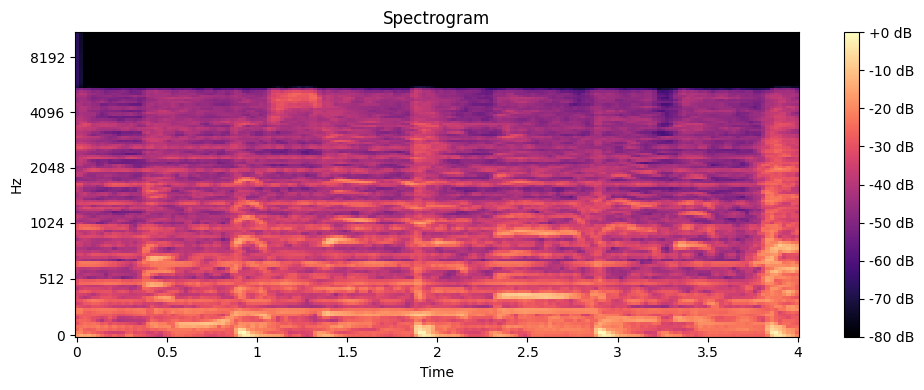

(128, 173)


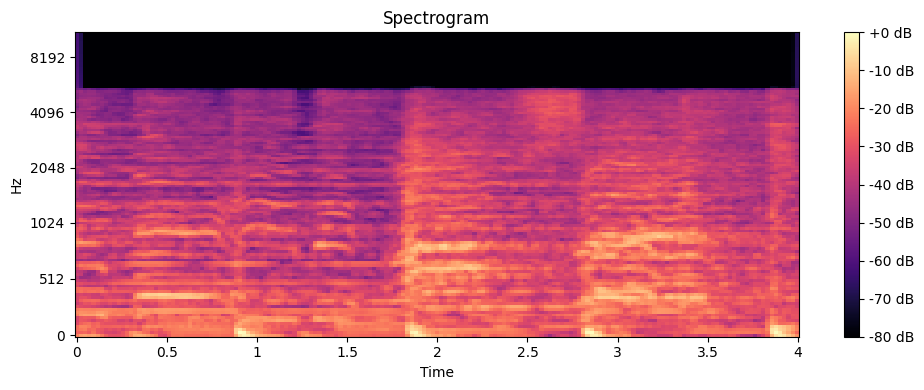

(128, 173)


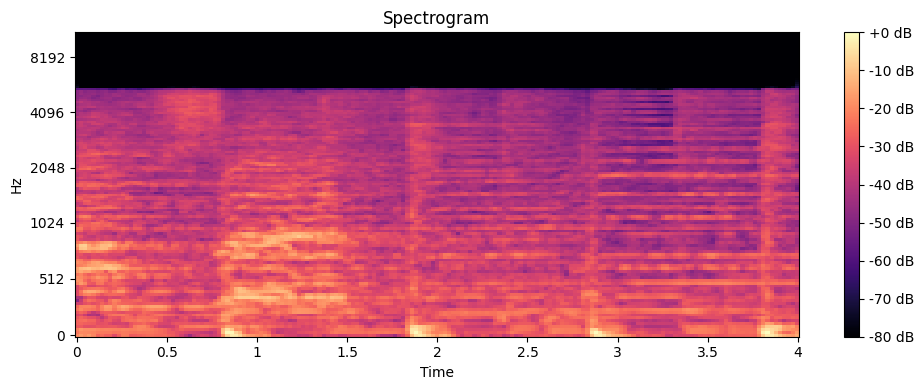

(128, 173)


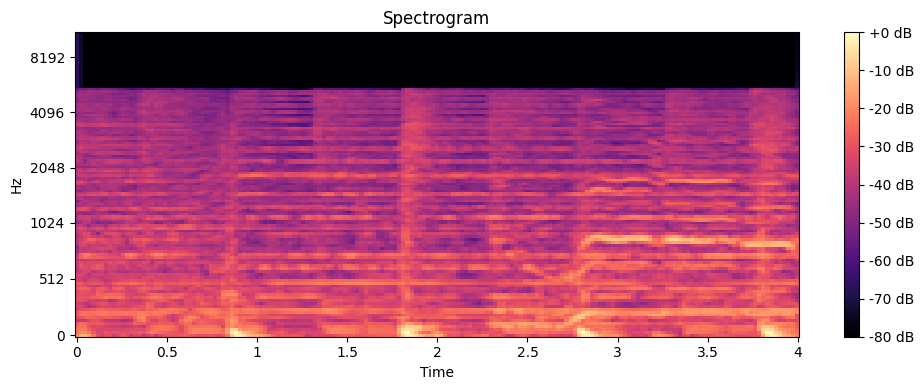

(128, 173)


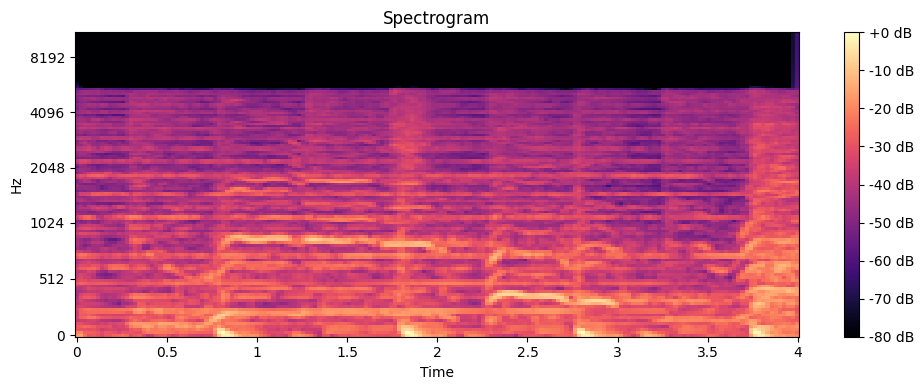

(128, 173)


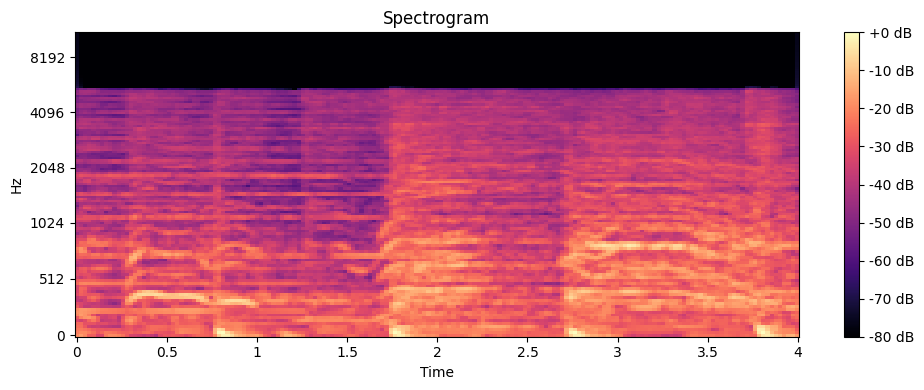

(128, 88)


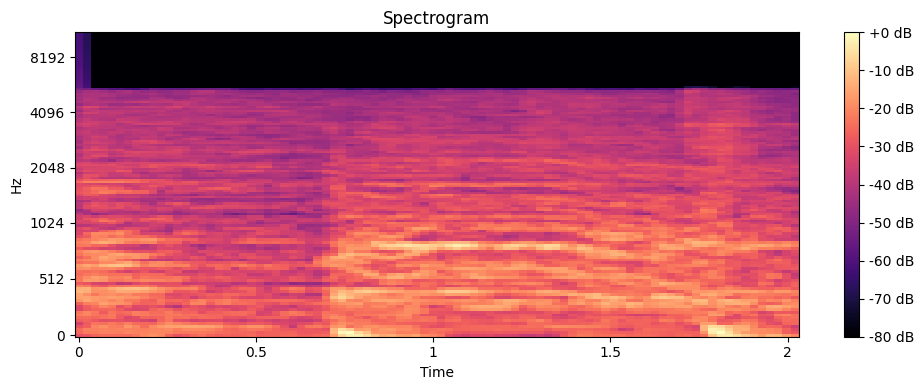

In [9]:
#Spectrogram of Audio chunks
plot_melspectrogram_chunks(y=x,sr=sr)

# Data Preprocessing

In [10]:
# Define your folder structure
data_dir = 'C:\\Users\\Admin\\OneDrive\\Desktop\\Music Genre Classification System\\Data\\genres_original'
classes = ['blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [11]:
import os
import numpy as np
import librosa
from skimage.transform import resize  # Assuming you're using skimage for resizing

def load_and_preprocess_data(data_dir, classes, target_shape=(150, 150)):
    data = []
    labels = []
    
    for i_class, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        print("Processing--", class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                
                # Try loading with soundfile backend, fallback to audioread if it fails
                try:
                    audio_data, sample_rate = librosa.load(file_path, sr=None)
                except Exception as e:
                    print(f"Error loading {filename} with soundfile, trying audioread: {e}")
                    try:
                        audio_data, sample_rate = librosa.load(file_path, sr=None, backend='audioread')
                    except Exception as e:
                        print(f"Error loading {filename} with audioread: {e}")
                        continue
                
                # Define chunk duration and overlap in seconds
                chunk_duration = 4  # seconds
                overlap_duration = 2  # seconds
                
                # Convert durations to samples
                chunk_samples = chunk_duration * sample_rate
                overlap_samples = overlap_duration * sample_rate
                
                if len(audio_data) < chunk_samples:
                    print(f"Skipping {filename} due to short length")
                    continue
                
                # Calculate the number of chunks
                num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
                
                for i in range(num_chunks):
                    # Calculate start and end indices of the chunk
                    start = i * (chunk_samples - overlap_samples)
                    end = start + chunk_samples
                    
                    # Extract the chunk of audio
                    chunk = audio_data[start:end]
                    
                    # If the chunk is shorter than the expected size, pad with zeros
                    if len(chunk) < chunk_samples:
                        chunk = np.pad(chunk, (0, chunk_samples - len(chunk)), mode='constant')
                    
                    # Compute the Mel spectrogram for the chunk
                    mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
                    
                    # Resize the Mel spectrogram to the target shape
                    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                    
                    # Append to data and labels
                    data.append(mel_spectrogram)
                    labels.append(i_class)
    
    return np.array(data), np.array(labels)


In [12]:
# Split data into training and testing sets
data, labels = load_and_preprocess_data(data_dir, classes)
print("\nData:",data,"\nlabel:",labels)

Processing-- blues
Processing-- classical
Processing-- country
Processing-- disco
Processing-- hiphop
Processing-- jazz


C:\Users\Admin\AppData\Local\Temp\ipykernel_8916\1009286436.py:19: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=None)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading jazz.00054.wav with soundfile, trying audioread: 
Error loading jazz.00054.wav with audioread: load() got an unexpected keyword argument 'backend'
Processing-- metal
Processing-- pop
Processing-- reggae
Processing-- rock

Data: [[[[1.16874754e+00]
   [1.42603135e+00]
   [1.13055432e+00]
   ...
   [3.31933093e+00]
   [2.85824299e+00]
   [2.27162981e+00]]

  [[1.92503405e+00]
   [3.32344270e+00]
   [6.47977924e+00]
   ...
   [6.89370775e+00]
   [5.51243401e+00]
   [2.54681897e+00]]

  [[1.02457631e+00]
   [2.07244229e+00]
   [5.91986752e+00]
   ...
   [1.03284092e+01]
   [8.72096920e+00]
   [5.80306435e+00]]

  ...

  [[1.05701190e-07]
   [1.24838124e-07]
   [2.10703590e-07]
   ...
   [2.05207769e-07]
   [4.93078733e-06]
   [5.86982933e-05]]

  [[4.46161437e-08]
   [2.03616892e-08]
   [1.70810459e-08]
   ...
   [2.23829453e-08]
   [4.67309928e-06]
   [5.80142041e-05]]

  [[3.41050495e-08]
   [1.18200889e-08]
   [5.88145621e-09]
   ...
   [6.49489751e-09]
   [4.62349180e-06]

In [13]:
data.shape

(14975, 150, 150, 1)

In [14]:
labels.shape

(14975,)

In [15]:
labels

array([0, 0, 0, ..., 9, 9, 9])

In [16]:
labels = to_categorical(labels, num_classes=len(classes))  # Convert labels to one-hot encoding
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [17]:
labels.shape

(14975, 10)

# Splitting Dataset into Training and Test set

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Building Model

In [19]:
model = tf.keras.models.Sequential()

In [20]:
X_train[0].shape

(150, 150, 1)

In [21]:
model.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=X_train[0].shape))
model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [23]:
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [24]:
model.add(tf.keras.layers.Dropout(0.3))

In [25]:
model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [26]:
model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

In [27]:
model.add(Dropout(0.3))

In [28]:
model.add(Flatten())

In [29]:
model.add(Dense(units=1200,activation='relu'))

In [30]:
model.add(Dropout(0.45))

In [31]:
#Output Layer
model.add(Dense(units=len(classes),activation='softmax'))

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 148, 148, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1200)           │     2,458,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [34]:
X_train.shape,y_train.shape

((11980, 150, 150, 1), (11980, 10))

In [35]:
# Train the model
training_history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 542s 1s/step - accuracy: 0.1984 - loss: 2.1347 - val_accuracy: 0.3900 - val_loss: 1.6842
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.4367 - loss: 1.5628 - val_accuracy: 0.5506 - val_loss: 1.2446
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 527s 1s/step - accuracy: 0.5830 - loss: 1.1821 - val_accuracy: 0.6715 - val_loss: 0.9770
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.6701 - loss: 0.9724 - val_accuracy: 0.6992 - val_loss: 0.8848
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 445s 1s/step - accuracy: 0.7234 - loss: 0.8122 - val_accuracy: 0.7159 - val_loss: 0.8109
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 1051s 3s/step - accuracy: 0.7538 - loss: 0.7225 - val_accuracy: 0.7710 - val_loss: 0.6818
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2243s 6s/step - accuracy: 0.7962 - loss: 0.6004 - val_accuracy: 0.8154 - val_loss: 0.5653
Epoch 8/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 2089s 6s/step - accuracy: 0.8498 - loss: 0.4532 - val_a

In [36]:
model.save("Trained_model.h5")

In [37]:
training_history.history

{'accuracy': [0.25801336765289307,
  0.4817195236682892,
  0.5997495651245117,
  0.6795492768287659,
  0.7299666404724121,
  0.7647746205329895,
  0.8037562370300293,
  0.8442404270172119,
  0.8594323992729187,
  0.8846410512924194,
  0.898330569267273,
  0.9137729406356812,
  0.9287980198860168,
  0.9353088736534119,
  0.9419031739234924,
  0.9495826363563538,
  0.9552587866783142,
  0.9564273953437805,
  0.9652754664421082,
  0.9648581147193909,
  0.9680300354957581,
  0.9694491028785706,
  0.9758764505386353,
  0.9727879762649536,
  0.9727045297622681,
  0.9752921462059021,
  0.9802170395851135,
  0.9856427311897278,
  0.9782971739768982,
  0.9829716086387634],
 'loss': [1.9955179691314697,
  1.439510703086853,
  1.1439847946166992,
  0.9386042356491089,
  0.7945646047592163,
  0.6907157301902771,
  0.5754460692405701,
  0.4612036943435669,
  0.40902969241142273,
  0.33692675828933716,
  0.29724738001823425,
  0.2528769075870514,
  0.2202489972114563,
  0.18833458423614502,
  0.1635

In [38]:
#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

# Model Evaluation

In [39]:
##Model Evaluation on Training set
train_accuracy=model.evaluate(X_train,y_train,verbose=0)
print(train_accuracy[1])

0.9771285653114319


In [40]:
##Model Evaluation on Test set
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8801335692405701


# Accuracy and Loss Visualization

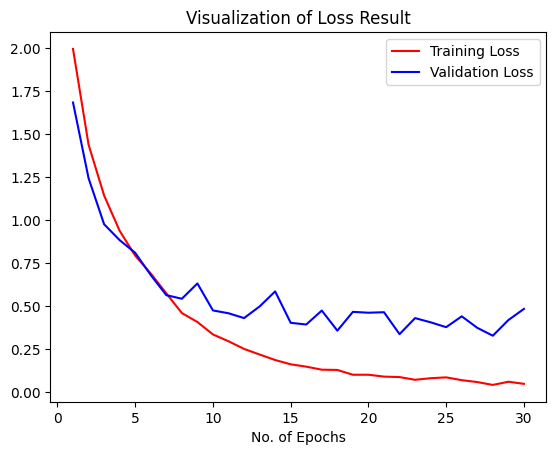

In [41]:
#Visualization of Loss
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history.history['loss'],color='red',label='Training Loss')
plt.plot(epochs,training_history.history['val_loss'],color='blue',label='Validation Loss')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Loss Result')
plt.legend()
plt.show()

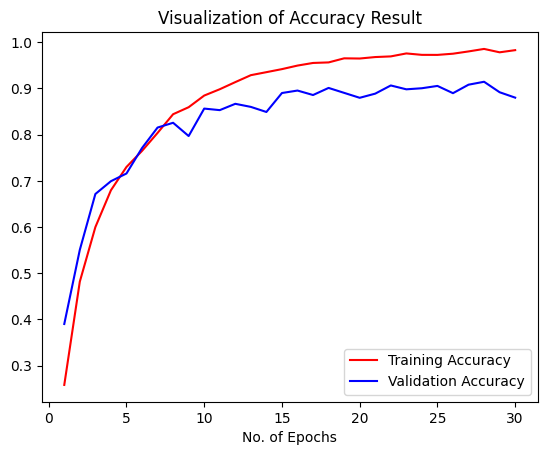

In [42]:
#Accuracy Visualization
plt.plot(epochs,training_history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(epochs,training_history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

# Precision, Recall, Confusion Metrics calculation

In [43]:
y_pred = model.predict(X_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 275ms/step


In [44]:
y_pred

array([[9.39872007e-06, 5.82704978e-08, 4.25164413e-04, ...,
        9.97937202e-01, 2.85886763e-05, 5.71426819e-04],
       [1.40982901e-13, 1.09830944e-16, 1.15748763e-14, ...,
        2.40028306e-16, 5.13435903e-16, 3.66859382e-07],
       [6.82288503e-10, 1.79001913e-09, 4.20802948e-10, ...,
        2.07394479e-09, 5.99378078e-13, 2.18412909e-03],
       ...,
       [9.56404567e-01, 7.66011041e-08, 4.32538800e-02, ...,
        3.33399868e-08, 2.81183340e-04, 3.08069211e-05],
       [6.07859576e-04, 9.82918978e-01, 1.03683246e-03, ...,
        6.19697478e-03, 2.99793645e-03, 8.75921047e-04],
       [9.13671777e-02, 4.71744585e-07, 1.48109498e-03, ...,
        3.88036511e-04, 6.48361049e-04, 3.24768692e-01]], dtype=float32)

In [45]:
y_pred.shape

(2995, 10)

In [46]:
predicted_categories = np.argmax(y_pred, axis=1)
predicted_categories

array([7, 6, 6, ..., 0, 1, 4], dtype=int64)

In [47]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
true_categories = np.argmax(y_test, axis=1)
true_categories

array([7, 6, 6, ..., 0, 1, 4], dtype=int64)

In [49]:
classes

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [50]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(true_categories,predicted_categories)
# Precision Recall F1score
print(classification_report(true_categories,predicted_categories,target_names=classes))

              precision    recall  f1-score   support

       blues       0.92      0.92      0.92       302
   classical       0.85      0.99      0.91       298
     country       0.71      0.92      0.80       317
       disco       0.89      0.90      0.89       312
      hiphop       0.98      0.83      0.90       277
        jazz       1.00      0.80      0.89       311
       metal       0.90      0.98      0.94       302
         pop       0.90      0.89      0.89       289
      reggae       0.92      0.83      0.88       296
        rock       0.84      0.74      0.79       291

    accuracy                           0.88      2995
   macro avg       0.89      0.88      0.88      2995
weighted avg       0.89      0.88      0.88      2995



# Confusion Matrix Visualization

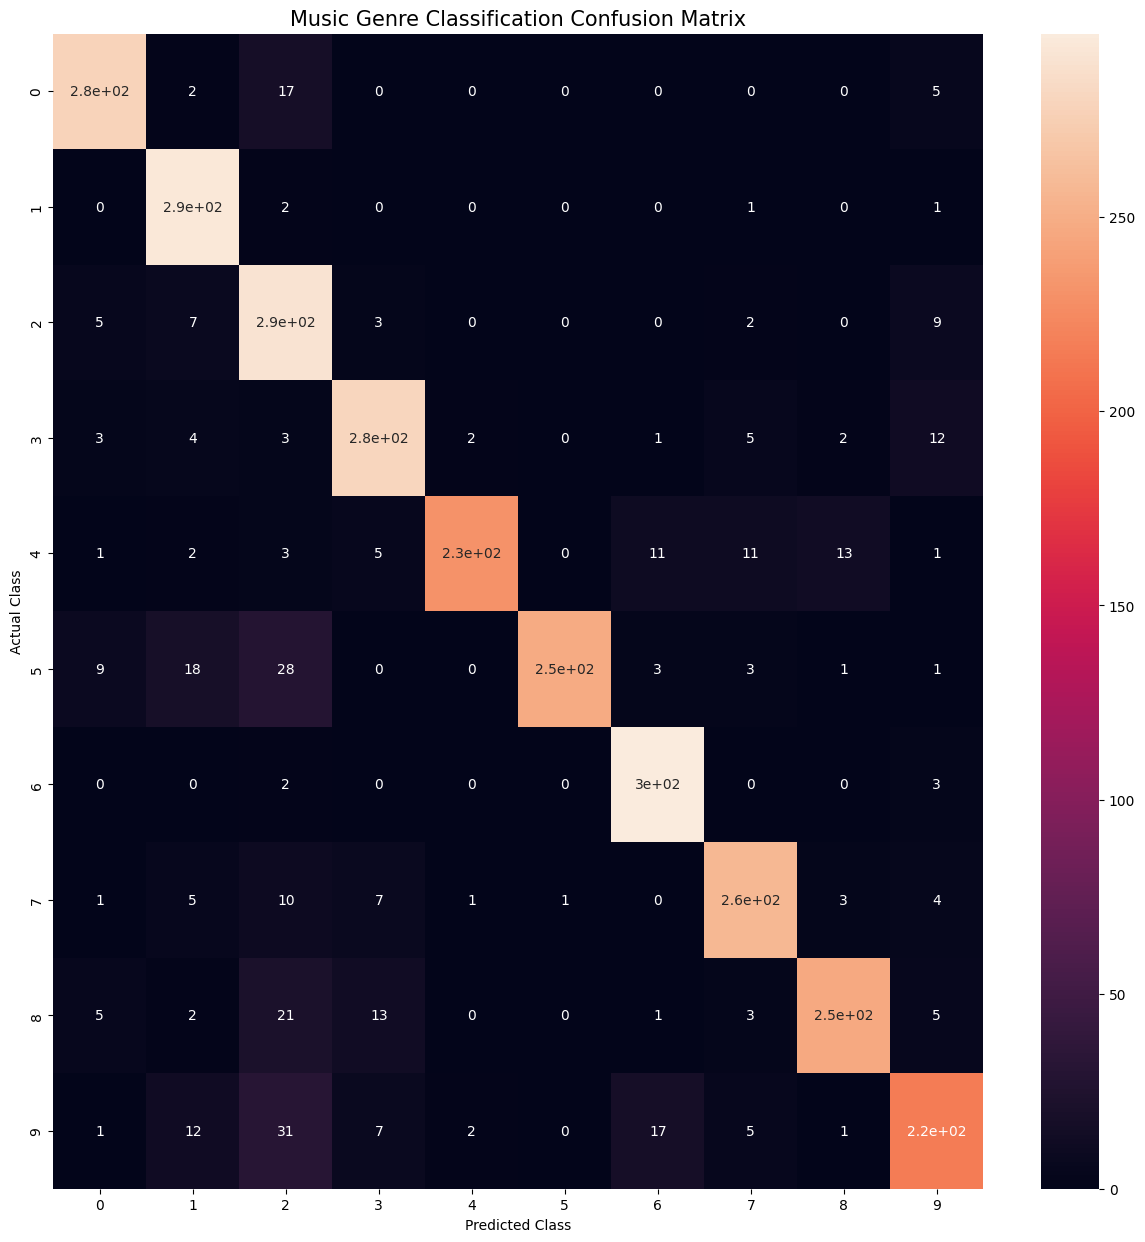

In [51]:
plt.figure(figsize=(15, 15))
sns.heatmap(cm,annot=True,annot_kws={"size": 10})

plt.xlabel('Predicted Class',fontsize = 10)
plt.ylabel('Actual Class',fontsize = 10)
plt.title('Music Genre Classification Confusion Matrix',fontsize = 15)
plt.show()